# IMPORTING LIBRARIES:

In [2]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import random
import os
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# READING THE DATASET:

In [3]:
train_dir = r'E:\Github\Medical-image-analysis-for-brain-tumor-detection\Dataset\Training'
test_dir = r'E:\Github\Medical-image-analysis-for-brain-tumor-detection\Dataset\Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    # Construct full path to the label directory
    label_dir = os.path.join(train_dir, label)
    # Iterate through images in each class directory
    for image in os.listdir(label_dir):
        # Construct full path to each image
        image_path = os.path.join(label_dir, image)
        train_paths.append(image_path)
        train_labels.append(label)

# Shuffle the data
train_paths, train_labels = shuffle(train_paths, train_labels)

### Creating a pie chart 




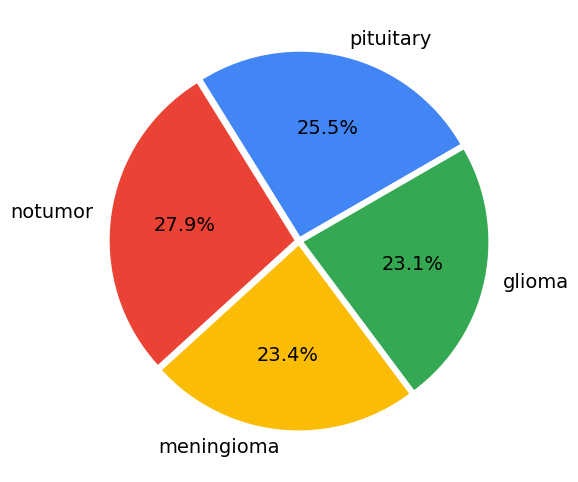

In [4]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

# Dateset is Reasonably Balanced.

In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    # Construct full path to the label directory
    label_dir = os.path.join(test_dir, label)
    # Iterate through images in each class directory
    for image in os.listdir(label_dir):
        # Construct full path to each image
        image_path = os.path.join(label_dir, image)
        test_paths.append(image_path)
        test_labels.append(label)

# Shuffle the data
test_paths, test_labels = shuffle(test_paths, test_labels)

### Creating a pie chart 




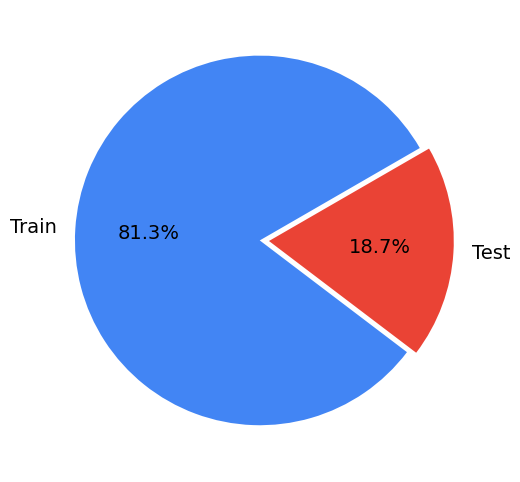

In [6]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# DATA AUGMENTATION:

In [7]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

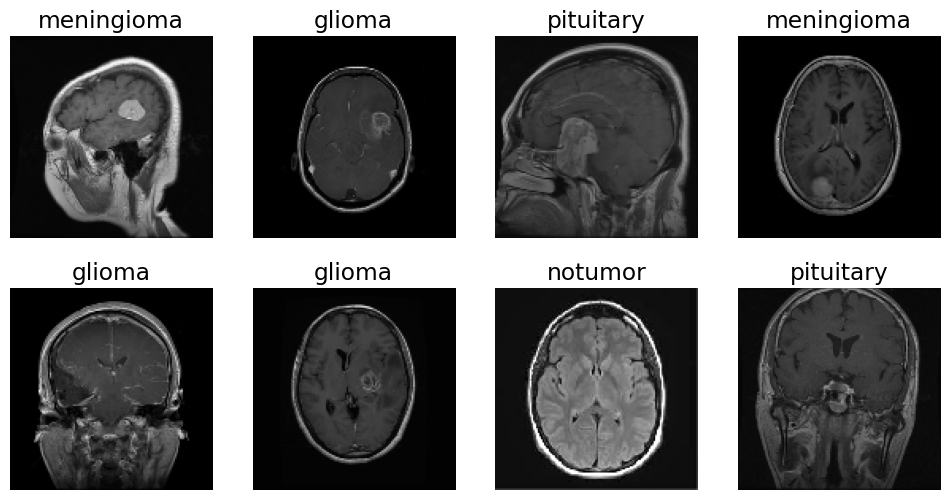

In [8]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

# DATA GENERATOR 

In [9]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

In [10]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

### Model Summary

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Model Complie

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

# TRAINING THE MODEL:

In [20]:
batch_size = 32
steps = int(len(train_paths)/batch_size)
epochs = 8
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - loss: 0.1627 - sparse_categorical_accuracy: 0.9412
Epoch 2/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - loss: 0.1230 - sparse_categorical_accuracy: 0.9575
Epoch 3/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - loss: 0.0919 - sparse_categorical_accuracy: 0.9679
Epoch 4/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - loss: 0.0776 - sparse_categorical_accuracy: 0.9689
Epoch 5/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - loss: 0.0553 - sparse_categorical_accuracy: 0.9809
Epoch 6/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - loss: 0.0540 - sparse_categorical_accuracy: 0.9822
Epoch 7/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - loss: 0.0393 - sparse_categorical_accuracy: 0.9856
Epoch 8/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 505s 3s/step - loss: 0.0346 - sparse_categorical_accuracy: 0.9894


In [21]:
# batch_size = 32
# steps_per_epoch = int(len(train_paths) / batch_size)
# epochs = 6

# # Define data generators for training (modify for your data augmentation)
# train_datagen = datagen(train_paths, train_labels, batch_size=batch_size)

# # Train the model with training data
# history = model.fit(train_datagen, steps_per_epoch=steps_per_epoch, epochs=epochs,)

In [22]:
# Define data generator for testing (no augmentation typically)
test_datagen = datagen(test_paths, test_labels, batch_size=batch_size)
test_steps = int(len(test_paths) / batch_size)

# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate(test_datagen, steps=test_steps)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9853
Test loss: 0.060969430953264236
Test accuracy: 0.981249988079071


In [25]:
# # Get predictions on the testing data
# predictions = model.predict(test_datagen)

# # Convert predicted probabilities to class labels (assuming categorical labels)
# predicted_classes = np.argmax(predictions, axis=1)

# # Generate classification report (assuming you have imported scikit-learn metrics)
# from sklearn.metrics import classification_report

# print('Classification Report:')
# print(classification_report(test_labels, predicted_classes))

## Creating a plot of the training history of the model

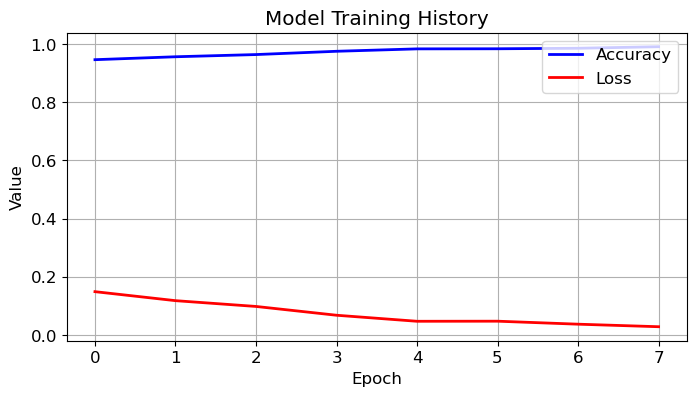

In [23]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

# EVALUATING MODEL WITH TEST SAMPLES:

In [25]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  2%|██                                                                                 | 1/40 [00:02<01:50,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  5%|████▏                                                                              | 2/40 [00:05<01:36,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  8%|██████▏                                                                            | 3/40 [00:07<01:31,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 10%|████████▎                                                                          | 4/40 [00:09<01:27,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 12%|██████████▍                                                                        | 5/40 [00:12<01:24,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 15%|████████████▍                                                                      | 6/40 [00:14<01:21,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 18%|██████████████▌                                                                    | 7/40 [00:17<01:22,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 20%|████████████████▌                                                                  | 8/40 [00:19<01:19,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 22%|██████████████████▋                                                                | 9/40 [00:22<01:17,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 25%|████████████████████▌                                                             | 10/40 [00:24<01:14,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 28%|██████████████████████▌                                                           | 11/40 [00:27<01:13,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 30%|████████████████████████▌                                                         | 12/40 [00:29<01:09,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 32%|██████████████████████████▋                                                       | 13/40 [00:32<01:06,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 35%|████████████████████████████▋                                                     | 14/40 [00:34<01:02,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:36<00:59,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:39<00:56,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:41<00:55,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:44<00:55,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:46<00:52,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:49<00:51,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:52<00:47,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:54<00:46,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:57<00:43,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:59<00:39,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [01:01<00:37,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [01:04<00:35,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [01:07<00:33,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [01:09<00:30,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:12<00:27,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:14<00:24,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:16<00:21,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:19<00:19,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:21<00:16,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:24<00:14,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:26<00:11,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:28<00:09,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:31<00:07,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:33<00:04,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:35<00:02,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:38<00:00,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


41it [01:41,  2.48s/it]                                                                                                


## Classification Report

In [26]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.97      0.98      0.97       300
  meningioma       0.97      0.95      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



# Test The Images

In [27]:
def names(number):
    if number==0:
        return 'No, Its not a tumor'
    else:
        return 'Its a Tumor'

In [28]:
from PIL import Image

100.0% Conclusion: Its a Tumor


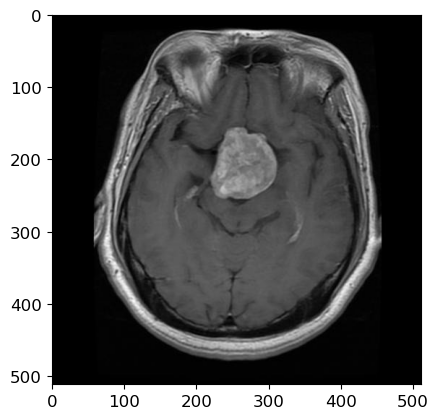

In [29]:
from matplotlib.pyplot import imshow
img = Image.open(r"E:\Github\Medical-image-analysis-for-brain-tumor-detection\Dataset\Testing\pituitary\Te-pi_0025.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: Its a Tumor


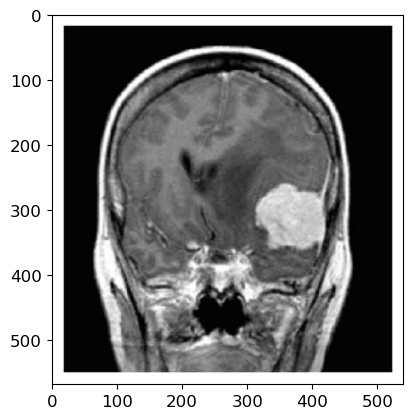

In [30]:
from matplotlib.pyplot import imshow
img = Image.open(r"E:\Github\Medical-image-analysis-for-brain-tumor-detection\Dataset\Testing\meningioma\Te-me_0014.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

100.0% Conclusion: No, Its not a tumor


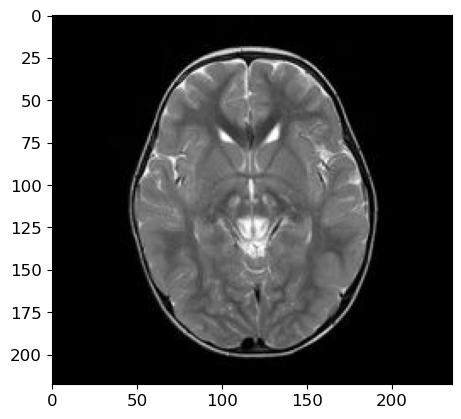

In [31]:
def names(number):
    if number==0:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'   
from matplotlib.pyplot import imshow
img = Image.open(r"E:\Github\Medical-image-analysis-for-brain-tumor-detection\Dataset\Testing\notumor\Te-no_0016.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Conclusion: ' + names(classification))

# 2nd Model: CNN

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam

In [33]:
# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

# Add convolutional and pooling layers
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Add fully connected layers
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(len(unique_labels), activation='softmax'))

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

In [35]:
# Train the model
batch_size = 32
steps = int(len(train_paths) / batch_size)
epochs = 10
history_1 = cnn_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                        epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 65s 340ms/step - loss: 1.0289 - sparse_categorical_accuracy: 0.5238
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 62s 347ms/step - loss: 0.5710 - sparse_categorical_accuracy: 0.7904
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 60s 337ms/step - loss: 0.4667 - sparse_categorical_accuracy: 0.8272
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 59s 331ms/step - loss: 0.3980 - sparse_categorical_accuracy: 0.8505
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 59s 329ms/step - loss: 0.3675 - sparse_categorical_accuracy: 0.8597
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 58s 327ms/step - loss: 0.3220 - sparse_categorical_accuracy: 0.8790
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 61s 341ms/step - loss: 0.2886 - sparse_categorical_accuracy: 0.8896
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 59s 334ms/step - loss: 0.2559 - sparse_categorical_accuracy: 0.9025
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 61s 340ms/step - loss: 0.2320 - sparse_categorical_accuracy: 0.9106
Epoch 10/10
178/178 ━━━━━━━━

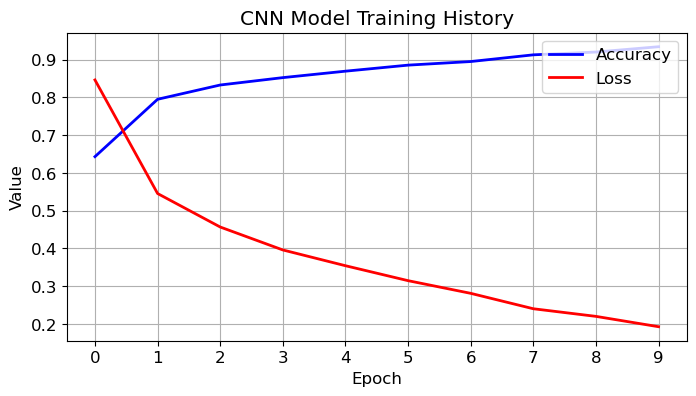

In [36]:
# Create a plot of the training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_1.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_1.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('CNN Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_1.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [39]:
# Assuming test_paths and test_labels are already defined
test_steps = int(len(test_paths) / batch_size)
test_datagen = datagen(test_paths, test_labels, batch_size=batch_size)

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_datagen, steps=test_steps)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - loss: 0.2657 - sparse_categorical_accuracy: 0.8925
Test Loss: 0.26817288994789124
Test Accuracy: 0.8843749761581421


In [41]:
# Evaluate the model
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred_1 = []
y_true_1 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred_1 = cnn_model.predict(x)
    pred_1 = np.argmax(pred_1, axis=-1)
    y_pred_1.extend(decode_label(pred_1))
    y_true_1.extend(decode_label(y))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


  2%|██                                                                                 | 1/40 [00:00<00:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  5%|████▏                                                                              | 2/40 [00:00<00:12,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  8%|██████▏                                                                            | 3/40 [00:00<00:11,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 10%|████████▎                                                                          | 4/40 [00:01<00:11,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 12%|██████████▍                                                                        | 5/40 [00:01<00:10,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 15%|████████████▍                                                                      | 6/40 [00:01<00:10,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 18%|██████████████▌                                                                    | 7/40 [00:02<00:10,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 20%|████████████████▌                                                                  | 8/40 [00:02<00:10,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 22%|██████████████████▋                                                                | 9/40 [00:02<00:10,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 25%|████████████████████▌                                                             | 10/40 [00:03<00:10,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:03<00:09,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:03<00:09,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:04<00:08,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:04<00:08,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:04<00:08,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:05<00:07,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:05<00:07,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:05<00:06,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:06<00:06,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:06<00:06,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:06<00:05,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:07<00:05,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:07<00:05,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:07<00:05,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:08<00:04,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:08<00:04,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:08<00:04,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:09<00:04,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:09<00:03,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:09<00:03,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:10<00:03,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:10<00:02,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:10<00:02,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:11<00:01,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:11<00:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:11<00:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:12<00:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:12<00:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:13<00:00,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:13<00:00,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


41it [00:14,  2.92it/s]                                                                                                


In [42]:
# Classification report
print(classification_report(y_true_1, y_pred_1))

              precision    recall  f1-score   support

      glioma       0.81      0.93      0.87       300
  meningioma       0.91      0.59      0.72       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.91      0.99      0.95       300

    accuracy                           0.88      1311
   macro avg       0.88      0.88      0.87      1311
weighted avg       0.89      0.88      0.88      1311



# 3rd model: DenseNet Model

In [43]:
from tensorflow.keras.applications import DenseNet121

In [44]:
# Load the DenseNet121 model without the top layers
base_model_2 = DenseNet121(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_2.layers:
    layer.trainable = False


In [45]:
# Set some layers to trainable if needed (example here, modify as necessary)
base_model_2.layers[-2].trainable = True
base_model_2.layers[-3].trainable = True
base_model_2.layers[-4].trainable = True

In [46]:
# Create the full model
densenet_model = Sequential()
densenet_model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
densenet_model.add(base_model_2)
densenet_model.add(Flatten())
densenet_model.add(Dropout(0.3))
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.2))
densenet_model.add(Dense(len(unique_labels), activation='softmax'))

densenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,135,300 (34.85 MB)

 Trainable params: 2,136,708 (8.15 MB)

 Non-trainable params: 6,998,592 (26.70 MB)

In [47]:
# Compile the model
densenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])


In [48]:
# Train the model
batch_size = 32
steps_2 = int(len(train_paths) / batch_size)
epochs = 10

history_2 = densenet_model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                             epochs=epochs, steps_per_epoch=steps_2)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 166s 753ms/step - loss: 0.7433 - sparse_categorical_accuracy: 0.7393
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 133s 748ms/step - loss: 0.2914 - sparse_categorical_accuracy: 0.8847
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 130s 733ms/step - loss: 0.2197 - sparse_categorical_accuracy: 0.9144
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 132s 741ms/step - loss: 0.1753 - sparse_categorical_accuracy: 0.9264
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 130s 733ms/step - loss: 0.1422 - sparse_categorical_accuracy: 0.9479
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 133s 746ms/step - loss: 0.1136 - sparse_categorical_accuracy: 0.9550
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 135s 756ms/step - loss: 0.0917 - sparse_categorical_accuracy: 0.9674
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 137s 769ms/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9679
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 134s 753ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9737
Epoch 10/10
178/178

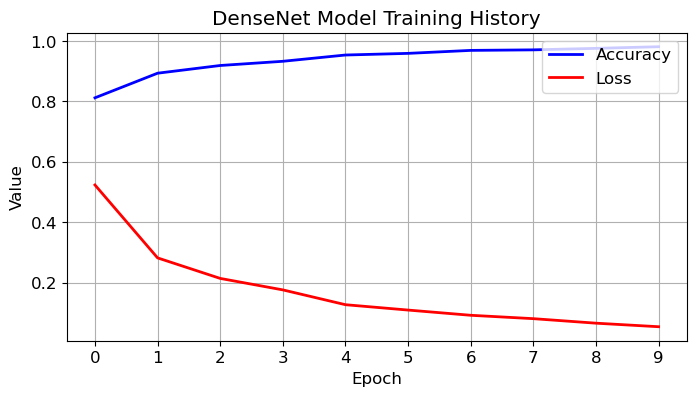

In [49]:
# Create a plot of the training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_2.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_2.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('DenseNet Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_2.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [50]:
# Assuming test_paths and test_labels are already defined
test_steps = int(len(test_paths) / batch_size)
test_datagen = datagen(test_paths, test_labels, batch_size=batch_size)

# Evaluate the model on the test data
test_loss, test_accuracy = densenet_model.evaluate(test_datagen, steps=test_steps)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 734ms/step - loss: 0.1360 - sparse_categorical_accuracy: 0.9498
Test Loss: 0.13951608538627625
Test Accuracy: 0.9476562738418579


In [51]:
# Evaluate the model
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred_2 = []
y_true_2 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred_2 = densenet_model.predict(x)
    pred_2 = np.argmax(pred_2, axis=-1)
    y_pred_2.extend(decode_label(pred_2))
    y_true_2.extend(decode_label(y))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|██                                                                                 | 1/40 [00:10<06:49, 10.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


  5%|████▏                                                                              | 2/40 [00:11<03:05,  4.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


  8%|██████▏                                                                            | 3/40 [00:12<01:55,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 10%|████████▎                                                                          | 4/40 [00:13<01:21,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 12%|██████████▍                                                                        | 5/40 [00:14<01:02,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 15%|████████████▍                                                                      | 6/40 [00:15<00:51,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 18%|██████████████▌                                                                    | 7/40 [00:16<00:44,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 20%|████████████████▌                                                                  | 8/40 [00:17<00:39,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 22%|██████████████████▋                                                                | 9/40 [00:18<00:35,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 25%|████████████████████▌                                                             | 10/40 [00:19<00:32,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:20<00:30,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:21<00:28,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:22<00:27,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:23<00:25,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:24<00:24,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:25<00:24,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:26<00:23,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:27<00:21,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:28<00:20,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:28<00:19,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:29<00:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:30<00:17,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:31<00:16,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:32<00:15,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:33<00:14,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:34<00:13,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:35<00:12,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:36<00:11,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:37<00:10,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:38<00:09,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:39<00:08,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:40<00:07,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:41<00:06,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:42<00:05,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:43<00:04,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:44<00:03,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:45<00:02,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:46<00:01,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:46<00:00,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:47<00:00,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


41it [00:57,  1.40s/it]                                                                                                


In [52]:
# Classification report
print(classification_report(y_true_2, y_pred_2))

              precision    recall  f1-score   support

      glioma       0.97      0.86      0.91       300
  meningioma       0.87      0.93      0.90       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



# 4rth Model: ResNet50 Model

In [53]:
from tensorflow.keras.applications import ResNet50

In [54]:
# Load the ResNet50 model without the top layers
base_model_3 = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_3.layers:
    layer.trainable = False

In [55]:
# Set the last few layers to trainable
base_model_3.layers[-2].trainable = True
base_model_3.layers[-3].trainable = True
base_model_3.layers[-4].trainable = True

In [56]:
# Create the full model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_3)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,782,660 (105.98 MB)

 Trainable params: 5,249,668 (20.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [57]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [58]:
# Train the model
batch_size = 32
steps_4 = int(len(train_paths) / batch_size)
epochs = 10
history_4 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_4)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 169s 847ms/step - loss: 0.9566 - sparse_categorical_accuracy: 0.5955
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 152s 856ms/step - loss: 0.5848 - sparse_categorical_accuracy: 0.7631
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 144s 809ms/step - loss: 0.5282 - sparse_categorical_accuracy: 0.7785
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 135s 759ms/step - loss: 0.4819 - sparse_categorical_accuracy: 0.7952
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 125s 703ms/step - loss: 0.4606 - sparse_categorical_accuracy: 0.8120
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 126s 708ms/step - loss: 0.4102 - sparse_categorical_accuracy: 0.8281
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 128s 721ms/step - loss: 0.4089 - sparse_categorical_accuracy: 0.8312
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 131s 738ms/step - loss: 0.4042 - sparse_categorical_accuracy: 0.8272
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 128s 722ms/step - loss: 0.3678 - sparse_categorical_accuracy: 0.8428
Epoch 10/10
178/178

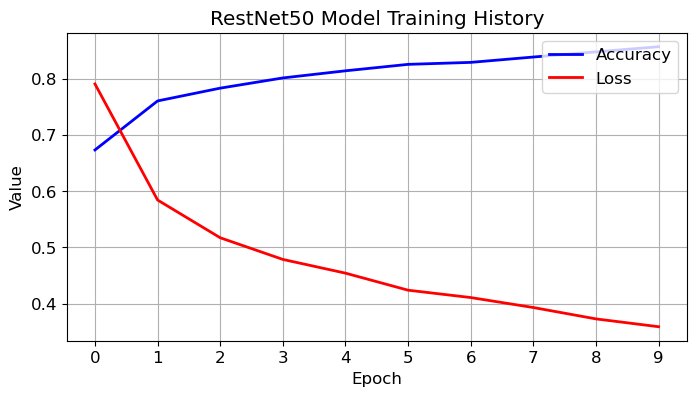

In [59]:
# Create a plot of the training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_4.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_4.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('RestNet50 Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_4.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [60]:
# Assuming test_paths and test_labels are already defined
test_steps = int(len(test_paths) / batch_size)
test_datagen = datagen(test_paths, test_labels, batch_size=batch_size)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_datagen, steps=test_steps)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 786ms/step - loss: 0.4347 - sparse_categorical_accuracy: 0.8072
Test Loss: 0.4369763433933258
Test Accuracy: 0.811718761920929


In [61]:
# Evaluate the model
batch_size = 32
steps_4 = int(len(test_paths) / batch_size)
y_pred_3 = []
y_true_3 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_4):
    pred_3 = model.predict(x)
    pred_3 = np.argmax(pred_3, axis=-1)
    y_pred_3.extend(decode_label(pred_3))
    y_true_3.extend(decode_label(y))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  2%|██                                                                                 | 1/40 [00:06<03:55,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


  5%|████▏                                                                              | 2/40 [00:07<01:57,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


  8%|██████▏                                                                            | 3/40 [00:08<01:19,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 10%|████████▎                                                                          | 4/40 [00:09<01:00,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 12%|██████████▍                                                                        | 5/40 [00:10<00:50,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


 15%|████████████▍                                                                      | 6/40 [00:11<00:45,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 18%|██████████████▌                                                                    | 7/40 [00:12<00:41,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 20%|████████████████▌                                                                  | 8/40 [00:13<00:37,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 22%|██████████████████▋                                                                | 9/40 [00:14<00:34,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 25%|████████████████████▌                                                             | 10/40 [00:15<00:32,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:16<00:30,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:17<00:28,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:18<00:27,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:19<00:25,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:20<00:24,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:21<00:24,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:22<00:24,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:23<00:22,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:24<00:21,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:25<00:20,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:26<00:19,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:27<00:18,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:28<00:16,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:29<00:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:30<00:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:31<00:13,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:32<00:12,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:33<00:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:34<00:10,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:35<00:09,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:36<00:09,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:37<00:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:38<00:07,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:39<00:06,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:40<00:05,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:41<00:03,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:42<00:02,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:43<00:01,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:44<00:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:45<00:00,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


41it [00:50,  1.23s/it]                                                                                                


In [62]:
# Classification report
print(classification_report(y_true_3, y_pred_3))

              precision    recall  f1-score   support

      glioma       0.73      0.81      0.77       300
  meningioma       0.77      0.59      0.67       306
     notumor       0.93      0.91      0.92       405
   pituitary       0.83      0.96      0.89       300

    accuracy                           0.82      1311
   macro avg       0.82      0.82      0.81      1311
weighted avg       0.82      0.82      0.82      1311



# 5th Model: MobileNetV2 Model

In [63]:
from tensorflow.keras.applications import MobileNetV2

In [64]:
# Load the MobileNetV2 model without the top layers
base_model_4 = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_4.layers:
    layer.trainable = False

In [65]:
# Set the last few layers to trainable
base_model_4.layers[-2].trainable = True
base_model_4.layers[-3].trainable = True
base_model_4.layers[-4].trainable = True

In [66]:
# Create the full model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_4)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       2,621,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,880,068 (18.62 MB)

 Trainable params: 3,034,884 (11.58 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

In [67]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


In [69]:
# Train the model
batch_size = 20
steps_5 = int(len(train_paths) / batch_size)
epochs = 10
history_5 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_5)


Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 117s 361ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7841
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 57s 200ms/step - loss: 0.1585 - sparse_categorical_accuracy: 0.9392
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 56s 196ms/step - loss: 0.0836 - sparse_categorical_accuracy: 0.9695
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 56s 198ms/step - loss: 0.0535 - sparse_categorical_accuracy: 0.9803
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 55s 194ms/step - loss: 0.0470 - sparse_categorical_accuracy: 0.9855
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 55s 195ms/step - loss: 0.0387 - sparse_categorical_accuracy: 0.9875
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9938
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 57s 201ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9937
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 59s 206ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9908
Epoch 10/10
285/285 ━━━━━━━

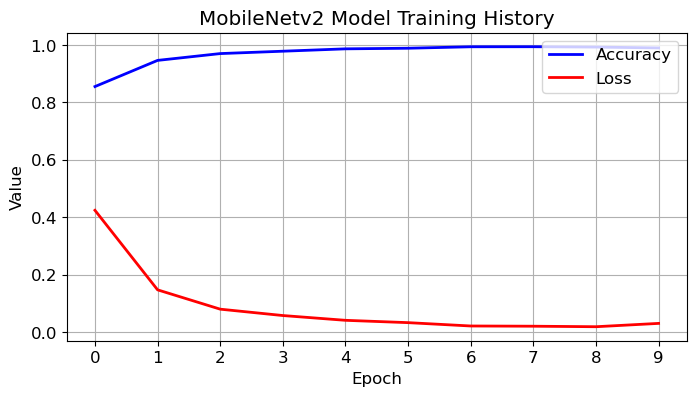

In [70]:
# Create a plot of the training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_5.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_5.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('MobileNetv2 Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_5.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [71]:
# Assuming test_paths and test_labels are already defined
test_steps = int(len(test_paths) / batch_size)
test_datagen = datagen(test_paths, test_labels, batch_size=batch_size)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_datagen, steps=test_steps)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 310ms/step - loss: 0.1840 - sparse_categorical_accuracy: 0.9538
Test Loss: 0.1865215301513672
Test Accuracy: 0.9538461565971375


In [72]:
# Evaluate the model
batch_size = 32
steps_5 = int(len(test_paths) / batch_size)
y_pred_4 = []
y_true_4 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_5):
    pred_4 = model.predict(x)
    pred_4 = np.argmax(pred_4, axis=-1)
    y_pred_4.extend(decode_label(pred_4))
    y_true_4.extend(decode_label(y))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  2%|██                                                                                 | 1/40 [00:03<02:13,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  5%|████▏                                                                              | 2/40 [00:03<01:02,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  8%|██████▏                                                                            | 3/40 [00:04<00:40,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 10%|████████▎                                                                          | 4/40 [00:04<00:28,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 12%|██████████▍                                                                        | 5/40 [00:05<00:23,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 15%|████████████▍                                                                      | 6/40 [00:05<00:20,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 18%|██████████████▌                                                                    | 7/40 [00:05<00:17,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 20%|████████████████▌                                                                  | 8/40 [00:06<00:15,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 22%|██████████████████▋                                                                | 9/40 [00:06<00:14,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|████████████████████▌                                                             | 10/40 [00:07<00:13,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:07<00:13,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:08<00:12,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:08<00:12,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:08<00:11,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:09<00:11,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:09<00:10,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:10<00:10,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:10<00:10,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:11<00:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:11<00:09,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:12<00:08,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:12<00:08,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:13<00:07,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:13<00:07,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:13<00:06,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:14<00:06,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:14<00:05,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:15<00:04,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:15<00:04,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:15<00:04,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:16<00:03,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:16<00:03,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:17<00:02,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:17<00:02,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:17<00:01,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:18<00:01,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:18<00:01,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:19<00:00,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:19<00:00,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:20<00:00,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


41it [00:23,  1.76it/s]                                                                                                


In [73]:
# Classification report
print(classification_report(y_true_4, y_pred_4))

              precision    recall  f1-score   support

      glioma       0.99      0.86      0.92       300
  meningioma       0.88      0.96      0.92       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.95      0.98      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



# 6th Model: VGG19

In [74]:
from tensorflow.keras.applications import VGG19

In [75]:
# Load the base model
base_model_5 = VGG19(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_5.layers:
    layer.trainable = False

In [76]:
# Set the last VGG block to trainable
base_model_5.layers[-2].trainable = True
base_model_5.layers[-3].trainable = True
base_model_5.layers[-4].trainable = True

In [77]:
# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_5)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,073,604 (80.39 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [78]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [79]:
# Train the model
batch_size = 32
steps_6 = int(len(train_paths) / batch_size)
epochs = 10
history_6 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_6)


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 613s 3s/step - loss: 0.7677 - sparse_categorical_accuracy: 0.6880
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 658s 4s/step - loss: 0.3021 - sparse_categorical_accuracy: 0.8847
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 590s 3s/step - loss: 0.2205 - sparse_categorical_accuracy: 0.9154
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - loss: 0.1622 - sparse_categorical_accuracy: 0.9410
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 554s 3s/step - loss: 0.1384 - sparse_categorical_accuracy: 0.9491
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1129s 6s/step - loss: 0.0983 - sparse_categorical_accuracy: 0.9649
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 479s 3s/step - loss: 0.0785 - sparse_categorical_accuracy: 0.9722
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 556s 3s/step - loss: 0.0727 - sparse_categorical_accuracy: 0.9720
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 472s 3s/step - loss: 0.0717 - sparse_categorical_accuracy: 0.9705
Epoch 10/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 482s

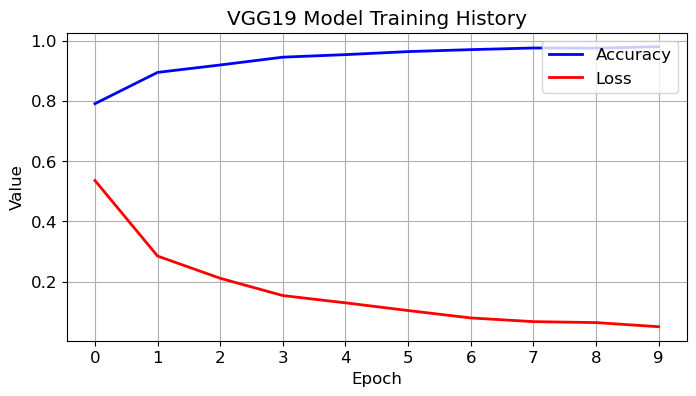

In [80]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_6.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_6.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('VGG19 Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_6.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()


In [81]:
# Assuming test_paths and test_labels are already defined
test_steps = int(len(test_paths) / batch_size)
test_datagen = datagen(test_paths, test_labels, batch_size=batch_size)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_datagen, steps=test_steps)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - loss: 0.0687 - sparse_categorical_accuracy: 0.9756
Test Loss: 0.08595982939004898
Test Accuracy: 0.9710937738418579


In [82]:
# Evaluate the model on the test set
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred_5 = []
y_true_5 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred_5 = model.predict(x)
    pred_5 = np.argmax(pred_5, axis=-1)
    for i in decode_label(pred_5):
        y_pred_5.append(i)
    for i in decode_label(y):
        y_true_5.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  2%|██                                                                                 | 1/40 [00:02<01:33,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  5%|████▏                                                                              | 2/40 [00:04<01:20,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  8%|██████▏                                                                            | 3/40 [00:06<01:16,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 10%|████████▎                                                                          | 4/40 [00:08<01:14,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 12%|██████████▍                                                                        | 5/40 [00:10<01:11,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 15%|████████████▍                                                                      | 6/40 [00:12<01:09,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 18%|██████████████▌                                                                    | 7/40 [00:14<01:08,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 20%|████████████████▌                                                                  | 8/40 [00:16<01:07,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 22%|██████████████████▋                                                                | 9/40 [00:19<01:07,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 25%|████████████████████▌                                                             | 10/40 [00:21<01:09,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 28%|██████████████████████▌                                                           | 11/40 [00:24<01:10,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 30%|████████████████████████▌                                                         | 12/40 [00:27<01:10,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 32%|██████████████████████████▋                                                       | 13/40 [00:29<01:09,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 35%|████████████████████████████▋                                                     | 14/40 [00:32<01:06,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:34<01:03,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:37<01:01,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:39<00:58,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:42<00:56,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:45<00:56,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:48<00:53,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:50<00:49,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:53<00:46,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:55<00:43,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:58<00:40,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [01:00<00:37,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [01:03<00:35,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [01:05<00:32,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [01:08<00:30,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:10<00:27,  2.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:13<00:25,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:15<00:22,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:18<00:20,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:21<00:18,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:24<00:16,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:26<00:13,  2.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:29<00:10,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:31<00:07,  2.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:34<00:05,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:36<00:02,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:39<00:00,  2.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


41it [01:41,  2.49s/it]                                                                                                


In [83]:
# Classification report
print(classification_report(y_true_5, y_pred_5))

              precision    recall  f1-score   support

      glioma       0.97      0.96      0.96       300
  meningioma       0.96      0.95      0.96       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.98      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311



# 7th Model: EfficientNet Model

In [84]:
from tensorflow.keras.applications import EfficientNetB0

In [85]:
# Load the base model
base_model_6 = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model_6.layers:
    layer.trainable = False

In [86]:
# Set the last few blocks to trainable
for layer in base_model_6.layers[-20:]:
    layer.trainable = True

In [87]:
# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_6)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 20480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       2,621,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,671,655 (25.45 MB)

 Trainable params: 3,973,044 (15.16 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [88]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [89]:
# Train the model
batch_size = 32
steps_7 = int(len(train_paths) / batch_size)
epochs = 8
history_7 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_7)

Epoch 1/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 99s 328ms/step - loss: 1.5386 - sparse_categorical_accuracy: 0.2546
Epoch 2/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 60s 339ms/step - loss: 1.3868 - sparse_categorical_accuracy: 0.2799
Epoch 3/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 56s 316ms/step - loss: 1.3892 - sparse_categorical_accuracy: 0.2753
Epoch 4/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 55s 310ms/step - loss: 1.3848 - sparse_categorical_accuracy: 0.2826
Epoch 5/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 57s 319ms/step - loss: 1.3826 - sparse_categorical_accuracy: 0.2881
Epoch 6/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 646s 4s/step - loss: 1.3862 - sparse_categorical_accuracy: 0.2831
Epoch 7/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 56s 313ms/step - loss: 1.3852 - sparse_categorical_accuracy: 0.2839
Epoch 8/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 58s 327ms/step - loss: 1.3852 - sparse_categorical_accuracy: 0.2849


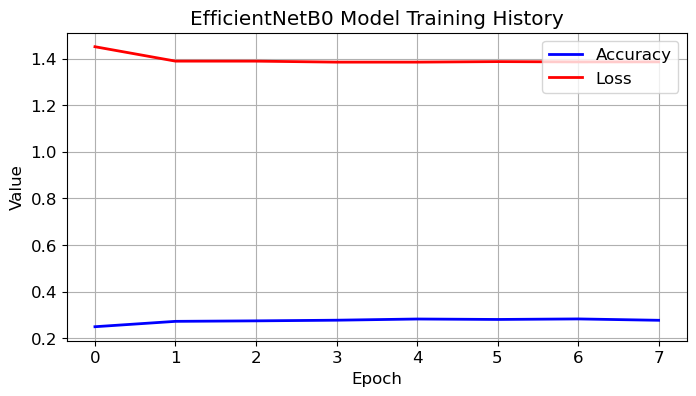

In [90]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_7.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_7.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('EfficientNetB0 Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_7.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()


In [91]:
# Assuming test_paths and test_labels are already defined
test_steps = int(len(test_paths) / batch_size)
test_datagen = datagen(test_paths, test_labels, batch_size=batch_size)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_datagen, steps=test_steps)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - loss: 1.3839 - sparse_categorical_accuracy: 0.3071
Test Loss: 1.3841891288757324
Test Accuracy: 0.30937498807907104


In [92]:
# Evaluate the model on the test set
batch_size = 32
steps_7 = int(len(test_paths) / batch_size)
y_pred_6 = []
y_true_6 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_7):
    pred_6 = model.predict(x)
    pred_6 = np.argmax(pred_6, axis=-1)
    for i in decode_label(pred_6):
        y_pred_6.append(i)
    for i in decode_label(y):
        y_true_6.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  2%|██                                                                                 | 1/40 [00:04<03:07,  4.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


  5%|████▏                                                                              | 2/40 [00:05<01:25,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  8%|██████▏                                                                            | 3/40 [00:05<00:53,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 10%|████████▎                                                                          | 4/40 [00:06<00:37,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 12%|██████████▍                                                                        | 5/40 [00:06<00:28,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 15%|████████████▍                                                                      | 6/40 [00:07<00:23,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 18%|██████████████▌                                                                    | 7/40 [00:07<00:20,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 20%|████████████████▌                                                                  | 8/40 [00:08<00:18,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 22%|██████████████████▋                                                                | 9/40 [00:08<00:16,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 25%|████████████████████▌                                                             | 10/40 [00:08<00:15,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:09<00:14,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:09<00:13,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:10<00:12,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:10<00:11,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:11<00:11,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:11<00:10,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:11<00:10,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:12<00:09,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:12<00:09,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:13<00:08,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:13<00:08,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:14<00:07,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:14<00:07,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:14<00:06,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:15<00:06,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:15<00:05,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:16<00:05,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:16<00:05,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:17<00:04,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:17<00:04,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:17<00:03,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:18<00:03,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:18<00:03,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:19<00:02,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:19<00:02,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:20<00:01,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:20<00:01,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:20<00:00,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:21<00:00,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


41it [00:27,  1.51it/s]                                                                                                


In [93]:
# Classification report
print(classification_report(y_true_6, y_pred_6))

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311



C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Advanced Models 

## 8th Model: Xception Model

In [94]:
from tensorflow.keras.applications import Xception

In [95]:
# Load the base model
base_model_7 = Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers
for layer in base_model_7.layers:
    layer.trainable = False

# Unfreeze the last few layers
for layer in base_model_7.layers[-20:]:
    layer.trainable = True

In [96]:
# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_7)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 4, 4, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,056,428 (95.58 MB)

 Trainable params: 11,521,324 (43.95 MB)

 Non-trainable params: 13,535,104 (51.63 MB)

In [97]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [98]:
# Train the model
batch_size = 32
steps_8 = int(len(train_paths) / batch_size)
epochs = 8
history_8 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_8)

Epoch 1/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - loss: 0.6505 - sparse_categorical_accuracy: 0.7540
Epoch 2/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - loss: 0.1470 - sparse_categorical_accuracy: 0.9466
Epoch 3/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - loss: 0.0478 - sparse_categorical_accuracy: 0.9820
Epoch 4/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 0.0232 - sparse_categorical_accuracy: 0.9920
Epoch 5/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9930
Epoch 6/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9871
Epoch 7/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9956
Epoch 8/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - loss: 0.0051 - sparse_categorical_accuracy: 0.9986


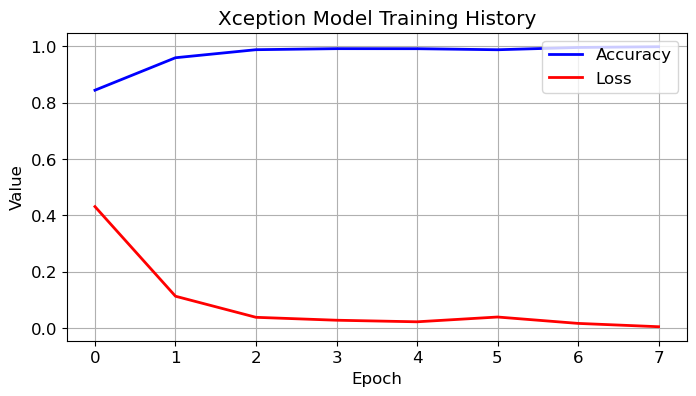

In [99]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_8.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_8.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('Xception Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_8.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [100]:
# Assuming test_paths and test_labels are already defined
test_steps = int(len(test_paths) / batch_size)
test_datagen = datagen(test_paths, test_labels, batch_size=batch_size)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_datagen, steps=test_steps)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 769ms/step - loss: 0.1562 - sparse_categorical_accuracy: 0.9674
Test Loss: 0.17220419645309448
Test Accuracy: 0.9624999761581421


In [101]:
# Evaluate the model on the test set
batch_size = 32
steps_8 = int(len(test_paths) / batch_size)
y_pred_7 = []
y_true_7 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_8):
    pred_7 = model.predict(x)
    pred_7 = np.argmax(pred_7, axis=-1)
    for i in decode_label(pred_7):
        y_pred_7.append(i)
    for i in decode_label(y):
        y_true_7.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  2%|██                                                                                 | 1/40 [00:02<01:56,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


  5%|████▏                                                                              | 2/40 [00:03<01:05,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


  8%|██████▏                                                                            | 3/40 [00:04<00:49,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 10%|████████▎                                                                          | 4/40 [00:05<00:41,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 12%|██████████▍                                                                        | 5/40 [00:06<00:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 15%|████████████▍                                                                      | 6/40 [00:07<00:33,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 18%|██████████████▌                                                                    | 7/40 [00:08<00:31,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 20%|████████████████▌                                                                  | 8/40 [00:08<00:29,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 22%|██████████████████▋                                                                | 9/40 [00:09<00:27,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 25%|████████████████████▌                                                             | 10/40 [00:10<00:26,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:11<00:25,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:12<00:24,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:13<00:23,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:14<00:22,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:15<00:22,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:15<00:20,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:16<00:19,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:17<00:18,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:18<00:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:19<00:17,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:20<00:16,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:20<00:15,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:21<00:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:22<00:13,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:23<00:13,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:24<00:13,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:25<00:12,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:26<00:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:27<00:10,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:28<00:09,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:29<00:08,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:30<00:07,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:31<00:06,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:32<00:05,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:33<00:04,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:34<00:03,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:35<00:02,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:36<00:01,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:37<00:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


41it [00:41,  1.02s/it]                                                                                                


In [102]:
# Classification report
print(classification_report(y_true_7, y_pred_7))

              precision    recall  f1-score   support

      glioma       0.99      0.87      0.93       300
  meningioma       0.88      0.97      0.92       306
     notumor       1.00      0.99      1.00       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



## 9th Model: NasNet Model

In [103]:
from tensorflow.keras.applications import NASNetLarge

In [104]:
# Load the base model
base_model_8 = NASNetLarge(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers
for layer in base_model_8.layers:
    layer.trainable = False

# Unfreeze the last few layers
for layer in base_model_8.layers[-20:]:
    layer.trainable = True

In [105]:
# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model_8)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ NASNet (Functional)                  │ (None, 4, 4, 4032)          │      84,916,818 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 64512)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64512)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       8,257,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,174,998 (355.43 MB)

 Trainable params: 10,574,564 (40.34 MB)

 Non-trainable params: 82,600,434 (315.10 MB)

In [106]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [107]:
# Train the model
batch_size = 32
steps_9 = int(len(train_paths) / batch_size)
epochs = 8
history_9 = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_9)


Epoch 1/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - loss: 0.7561 - sparse_categorical_accuracy: 0.7224
Epoch 2/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - loss: 0.2636 - sparse_categorical_accuracy: 0.9028
Epoch 3/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - loss: 0.1696 - sparse_categorical_accuracy: 0.9379
Epoch 4/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - loss: 0.1139 - sparse_categorical_accuracy: 0.9591
Epoch 5/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - loss: 0.0867 - sparse_categorical_accuracy: 0.9718
Epoch 6/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - loss: 0.0607 - sparse_categorical_accuracy: 0.9805
Epoch 7/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - loss: 0.0445 - sparse_categorical_accuracy: 0.9851
Epoch 8/8
178/178 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - loss: 0.0450 - sparse_categorical_accuracy: 0.9852


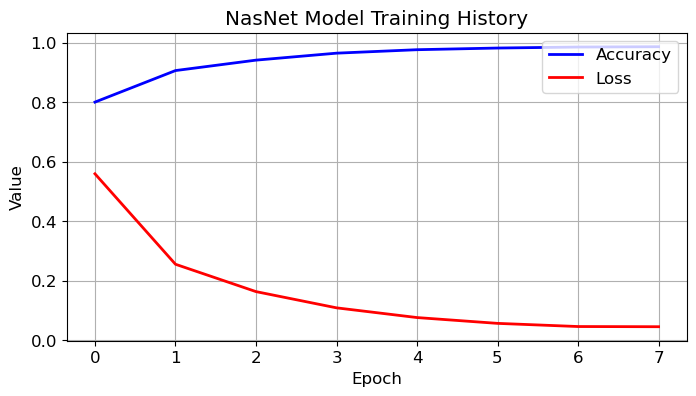

In [108]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history_9.history['sparse_categorical_accuracy'], 'b-', linewidth=2, label='Accuracy')
plt.plot(history_9.history['loss'], 'r-', linewidth=2, label='Loss')
plt.title('NasNet Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(len(history_9.history['sparse_categorical_accuracy'])))
plt.legend(loc='upper right')
plt.show()

In [109]:
# Assuming test_paths and test_labels are already defined
test_steps = int(len(test_paths) / batch_size)
test_datagen = datagen(test_paths, test_labels, batch_size=batch_size)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_datagen, steps=test_steps)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 0.3006 - sparse_categorical_accuracy: 0.9186
Test Loss: 0.35001593828201294
Test Accuracy: 0.91015625


In [110]:
# Evaluate the model on the test set
batch_size = 32
steps_9 = int(len(test_paths) / batch_size)
y_pred_9 = []
y_true_9 = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps_9):
    pred_9 = model.predict(x)
    pred_9 = np.argmax(pred_9, axis=-1)
    for i in decode_label(pred_9):
        y_pred_9.append(i)
    for i in decode_label(y):
        y_true_9.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|██                                                                                 | 1/40 [00:10<06:53, 10.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  5%|████▏                                                                              | 2/40 [00:12<03:26,  5.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  8%|██████▏                                                                            | 3/40 [00:14<02:19,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 10%|████████▎                                                                          | 4/40 [00:15<01:47,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 12%|██████████▍                                                                        | 5/40 [00:17<01:29,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 15%|████████████▍                                                                      | 6/40 [00:19<01:17,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 18%|██████████████▌                                                                    | 7/40 [00:21<01:10,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 20%|████████████████▌                                                                  | 8/40 [00:23<01:04,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 22%|██████████████████▋                                                                | 9/40 [00:24<01:00,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 25%|████████████████████▌                                                             | 10/40 [00:26<00:57,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 28%|██████████████████████▌                                                           | 11/40 [00:28<00:54,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 30%|████████████████████████▌                                                         | 12/40 [00:30<00:51,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 32%|██████████████████████████▋                                                       | 13/40 [00:32<00:49,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 35%|████████████████████████████▋                                                     | 14/40 [00:33<00:47,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:35<00:45,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:37<00:43,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:39<00:41,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:41<00:39,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:42<00:38,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:44<00:36,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:46<00:34,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:48<00:32,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:50<00:31,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:52<00:29,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:54<00:28,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:56<00:26,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:58<00:24,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:59<00:22,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [01:01<00:21,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [01:03<00:19,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [01:05<00:17,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [01:07<00:15,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [01:09<00:13,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:11<00:11,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [01:13<00:09,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:15<00:07,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:16<00:05,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:18<00:03,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:20<00:01,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:22<00:00,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


41it [01:35,  2.32s/it]                                                                                                


In [111]:
# Classification report
print(classification_report(y_true_9, y_pred_9))

              precision    recall  f1-score   support

      glioma       0.95      0.79      0.86       300
  meningioma       0.76      0.92      0.84       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.97      0.88      0.92       300

    accuracy                           0.90      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.90      0.90      1311



Conclusion :
